In [35]:
import matplotlib as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
import gensim
import re
import tensorflow as tf

# Importing Datasets #

In [36]:
dataset=pd.read_csv("twitter_training.csv")
validation=pd.read_csv("twitter_validation.csv")

In [37]:
dataset.head()

,2401,Borderlands,Positive,"im getting on borderlands and i will murder you all ,"
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...


In [38]:
dataset.rename(columns={'2401':'id','Positive':'Label','im getting on borderlands and i will murder you all ,':'tweet_text'},inplace=True)

In [39]:
validation.head()

,3364,Facebook,Irrelevant,"I mentioned on Facebook that I was struggling for motivation to go for a run the other day, which has been translated by Tom’s great auntie as ‘Hayley can’t get out of bed’ and told to his grandma, who now thinks I’m a lazy, terrible person 🤣"
0,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
1,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
2,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
3,4433,Google,Neutral,Now the President is slapping Americans in the...
4,6273,FIFA,Negative,Hi @EAHelp I’ve had Madeleine McCann in my cel...


In [40]:
validation.rename(columns={'3364':'id','Irrelevant':'Label','I mentioned on Facebook that I was struggling for motivation to go for a run the other day, which has been translated by Tom’s great auntie as ‘Hayley can’t get out of bed’ and told to his grandma, who now thinks I’m a lazy, terrible person 🤣':'tweet_text'},inplace=True)

# Visualising the Dataset

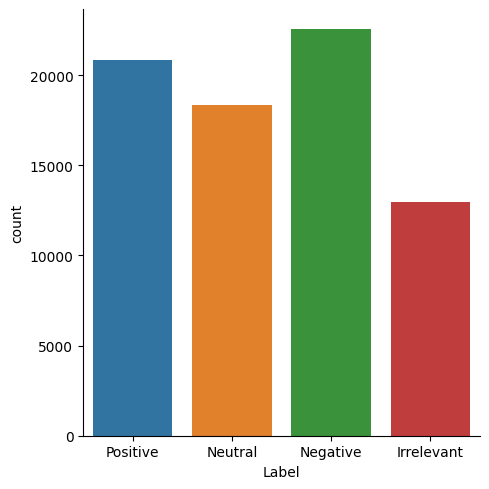

In [41]:
sns.catplot(x='Label',data=dataset,kind="count")

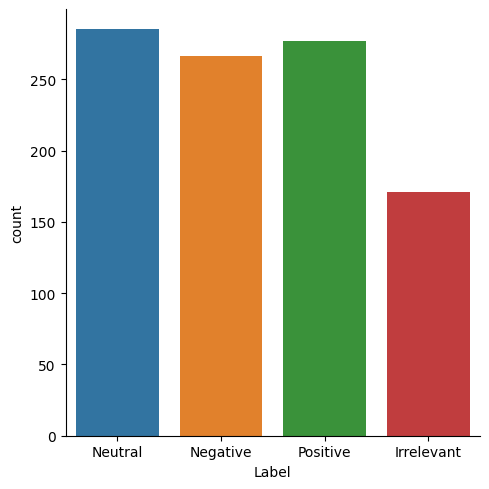

In [42]:
sns.catplot(x='Label',data=validation,kind="count")

# Sanitising Input Data #

In [43]:
dataset["Label"]=pd.Categorical(dataset["Label"])
dataset["label_Codes"]=dataset["Label"].cat.codes
dataset.head()

,id,Borderlands,Label,tweet_text,label_Codes
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...,3
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...,3
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...,3
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...,3
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...,3


In [44]:
validation["Label"]=pd.Categorical(validation["Label"])
validation["label_Codes"]=validation["Label"].cat.codes


In [ ]:
#train data
dataset['tweet_text'] = dataset['tweet_text'].str.replace(r"http\S+", "")
dataset['tweet_text'] = dataset['tweet_text'].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ")
#validation
validation['tweet_text'] = validation['tweet_text'].str.replace(r"http\S+", "")
validation['tweet_text'] = validation['tweet_text'].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ")

In [46]:
dataset=dataset.dropna(axis=0)

In [47]:
#Creating lists from sanitised data using the gensim preprocessor
#for training dataset
tweet_text_tokens=dataset.tweet_text.apply(gensim.utils.simple_preprocess)
dataset=dataset.drop('tweet_text',axis=1)
dataset=pd.concat([dataset,tweet_text_tokens],axis=1)
#for test dataset
test_tweet_text_tokens=validation.tweet_text.apply(gensim.utils.simple_preprocess)
validation=validation.drop('tweet_text',axis=1)
validation=pd.concat([validation,test_tweet_text_tokens],axis=1)
dataset.head()

,id,Borderlands,Label,label_Codes,tweet_text
0,2401,Borderlands,Positive,3,"[am, coming, to, the, borders, and, will, kill..."
1,2401,Borderlands,Positive,3,"[im, getting, on, borderlands, and, will, kill..."
2,2401,Borderlands,Positive,3,"[im, coming, on, borderlands, and, will, murde..."
3,2401,Borderlands,Positive,3,"[im, getting, on, borderlands, and, will, murd..."
4,2401,Borderlands,Positive,3,"[im, getting, into, borderlands, and, can, mur..."


# Using Word2Vec to generate features from tweet Texts #

In [48]:
total_tokens=pd.concat([tweet_text_tokens,test_tweet_text_tokens],axis=0)

In [49]:
vector_size_wv=10

In [50]:
model = gensim.models.Word2Vec(vector_size=vector_size_wv,window=5,min_count=2,workers=8,seed=0)
model.build_vocab(total_tokens, progress_per=1000)
model.train(total_tokens, total_examples=model.corpus_count, epochs=model.epochs)

(5483264, 6626995)

In [51]:
model.save("./word2vec-tweet_text_run2.model")

In [52]:
model.wv.most_similar("hate")

[('envision', 0.9040116667747498),
 ('mean', 0.866170346736908),
 ('lie', 0.8584302067756653),
 ('understand', 0.8572837114334106),
 ('bs', 0.8571985960006714),
 ('fault', 0.8549337983131409),
 ('think', 0.8494771718978882),
 ('isn', 0.8471360206604004),
 ('eyeballing', 0.8408141732215881),
 ('inventories', 0.8326768279075623)]

In [53]:
vocab=set(model.wv.index_to_key)

# Processing dataset using word2vec #

In [54]:
#making sentence array for train data
sen_array=[]
for ls in dataset['tweet_text']:
    sentence=[]
    for i in ls:
        if i in vocab:
            sentence.append(model.wv[i])
    sentence=np.array(sentence)
    sen_array.append(sentence)
#making sentence array for test data
sen_array_test=[]
for ls in validation['tweet_text']:
    sentence=[]
    for i in ls:
        if i in vocab:
            sentence.append(model.wv[i])
    sentence=np.array(sentence)
    sen_array_test.append(sentence)

In [55]:
#making sentence average vectors for train data
text_vect_avg = []
for v in sen_array:
    if v.size:
        text_vect_avg.append(v.mean(axis=0))
    else:
        text_vect_avg.append(np.zeros(vector_size_wv, dtype=float))# the same vector size must be used here as for model training
#making sentence average vectors for test data
text_vect_avg_test = []
for v in sen_array_test:
    if v.size:
        text_vect_avg_test.append(v.mean(axis=0))
    else:
        text_vect_avg_test.append(np.zeros(vector_size_wv, dtype=float))

In [56]:
dataset["sentence_average"]=text_vect_avg
validation["sentence_average"]=text_vect_avg_test
dataset.head()

,id,Borderlands,Label,label_Codes,tweet_text,sentence_average
0,2401,Borderlands,Positive,3,"[am, coming, to, the, borders, and, will, kill...","[1.4945418, -0.24269214, 0.30027682, -0.401684..."
1,2401,Borderlands,Positive,3,"[im, getting, on, borderlands, and, will, kill...","[2.1226943, -0.2604661, -0.50906956, -0.495062..."
2,2401,Borderlands,Positive,3,"[im, coming, on, borderlands, and, will, murde...","[1.8068693, -0.4442721, -0.10609577, -0.634026..."
3,2401,Borderlands,Positive,3,"[im, getting, on, borderlands, and, will, murd...","[1.8559815, -0.058187068, -0.66199845, -0.7629..."
4,2401,Borderlands,Positive,3,"[im, getting, into, borderlands, and, can, mur...","[2.1168928, -0.03821626, -0.932686, -0.8359249..."


In [57]:
y=dataset["label_Codes"]
test_y=validation["label_Codes"]

In [58]:
#converting the sentence average array to a pd dataframe so each value of array can be a feature
sentence_average_df=pd.DataFrame(text_vect_avg)
sentence_average_df.columns = ['Element_' + str(i+1) for i in range(0, sentence_average_df.shape[1])]
sentence_average_df_test=pd.DataFrame(text_vect_avg_test)
sentence_average_df_test.columns = ['Element_' + str(i+1) for i in range(0, sentence_average_df_test.shape[1])]
sentence_average_df.head()

,Element_1,Element_2,Element_3,Element_4,Element_5,Element_6,Element_7,Element_8,Element_9,Element_10
0,1.494542,-0.242692,0.300277,-0.401684,-0.023541,-1.419871,0.347138,-3.179668,-0.275618,3.157550
1,2.122694,-0.260466,-0.509070,-0.495063,-0.213043,-1.190740,0.363963,-3.013025,-0.580950,3.208760
2,1.806869,-0.444272,-0.106096,-0.634027,-0.198421,-0.992691,0.628381,-2.907631,-0.860523,2.858628
3,1.855981,-0.058187,-0.661998,-0.762924,0.139252,-1.168594,0.561640,-3.043900,-0.726695,3.111508
4,2.116893,-0.038216,-0.932686,-0.835925,-0.087352,-1.156843,0.404464,-3.014673,-0.696378,3.098598


In [59]:
#combining the dataset with sentence average
#X=pd.concat([X,sentence_average_df],axis=1)
X=sentence_average_df
#test_X=pd.concat([test_X,sentence_average_df_test],axis=1)
test_X=sentence_average_df_test
test_X.head()

,Element_1,Element_2,Element_3,Element_4,Element_5,Element_6,Element_7,Element_8,Element_9,Element_10
0,0.023882,0.234438,1.869475,-1.066573,0.120814,1.328772,0.068134,0.880032,-1.022812,1.063094
1,1.139982,0.522544,-0.336659,-1.036486,-0.106929,-1.095405,-0.113688,-1.512534,0.065654,3.103839
2,1.001100,-0.175949,-1.043757,-0.548436,-1.298016,0.194294,0.780545,-0.875793,-0.678026,2.548868
3,0.912775,0.280907,0.356943,-0.657953,-0.263398,0.083963,0.852793,-0.580248,0.018684,2.286164
4,1.869725,0.435754,-0.590611,-0.348064,0.190209,-0.955198,1.122008,-1.754163,-0.082472,3.128089


# Using Logistic Regression to predict target variables #

In [60]:
from sklearn.linear_model import LogisticRegression
lr=LogisticRegression(random_state = 0,max_iter=1000)
lr.fit(X,y)
y_pred_lr=lr.predict(test_X)

### Accuracy Metrics ###

In [61]:
from sklearn.metrics import confusion_matrix, accuracy_score,f1_score
cmlr = confusion_matrix(test_y, y_pred_lr)
print(cmlr)
f1_score(test_y, y_pred_lr,average='macro')

[[  1  66  49  55]
 [  0 203  27  36]
 [  1  81 148  55]
 [  1  85  54 137]]


0.40142686556567375

# Using enseable learning Methods to predict target variable #

## XGBOOST ##

In [62]:
import xgboost as xgb
classifierXGB=xgb.XGBClassifier()

In [63]:
classifierXGB.fit(X,y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [64]:
y_predXGB=classifierXGB.predict(test_X)

## Accuracy Metrics ##

In [65]:
cmXGB = confusion_matrix(test_y, y_predXGB)
print(cmXGB)
f1_score(test_y, y_predXGB,average='macro')

[[ 46  38  36  51]
 [  5 221  14  26]
 [ 11  60 155  59]
 [  4  42  34 197]]


0.5826586313540512

## Random Forest ##

In [66]:
from sklearn.ensemble import RandomForestClassifier
classifierRF = RandomForestClassifier(n_estimators=100,criterion = 'gini', random_state = 0)
classifierRF.fit(X, y)

RandomForestClassifier(random_state=0)

In [67]:
y_predRF=classifierRF.predict(test_X)

## Accuracy Metrics ##

In [68]:
cmRF = confusion_matrix(test_y, y_predRF)
print(cmRF)
f1_score(test_y, y_predRF,average='macro')

[[137   7  11  16]
 [  1 252   7   6]
 [  0  14 247  24]
 [  3  12  18 244]]


0.880823544133105

# Using Cross Validation #

In [76]:
from sklearn.model_selection import cross_validate
RF = RandomForestClassifier(n_estimators = 100, criterion = 'gini', random_state = 0)
LR=LogisticRegression(random_state = 0,max_iter=1000)
XGB=xgb.XGBClassifier()
RFscores=cross_validate(RF,X,y,scoring="f1_macro")
LRscores=cross_validate(LR,X,y,scoring="f1_macro")
XGBscores=cross_validate(XGB,X,y,scoring="f1_macro")
print(RFscores['test_score'])
print(LRscores['test_score'])
print(XGBscores['test_score'])

[0.42217422 0.41152766 0.3945956  0.3814583  0.43465219]
[0.39230168 0.37802663 0.37451951 0.36935206 0.41604957]
[0.43019961 0.41036499 0.39234339 0.39090419 0.4436174 ]


# Using Tf-IDF for word embeddings

## For Training Set

In [70]:
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
corpus=[]
for i in range(0,73995):
    tweet=re.sub('[^a-zA-Z]',' ',str(dataset['tweet_text'].iloc[i]))
    tweet=tweet.lower()
    tweet=tweet.split()
    ps=PorterStemmer()
    all_stopwords = stopwords.words('english')
    all_stopwords.remove('not')
    tweet = [ps.stem(word) for word in tweet if not word in set(all_stopwords)]
    tweet=' '.join(tweet)
    corpus.append(tweet)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Aayush\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [71]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf=TfidfVectorizer(max_features=1000)
new_text=tfidf.fit_transform(corpus).toarray()
print(new_text)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


## For Test Set

In [72]:
corpus2=[]
for i in range(0,999):
    tweet=re.sub('[^a-zA-Z]',' ',str(validation['tweet_text'].iloc[i]))
    tweet=tweet.lower()
    tweet=tweet.split()
    ps=PorterStemmer()
    all_stopwords = stopwords.words('english')
    all_stopwords.remove('not')
    tweet = [ps.stem(word) for word in tweet if not word in set(all_stopwords)]
    tweet=' '.join(tweet)
    corpus2.append(tweet)
new_text_test=tfidf.transform(corpus2).toarray()

In [73]:
tfidf_X=new_text
tfidf_y=dataset["label_Codes"]
tfidf_test_X=new_text_test
tfidf_test_y=validation["label_Codes"]

# Training Models

In [74]:
from sklearn.linear_model import LogisticRegression
lr_tfidf=LogisticRegression(random_state = 0,max_iter=1000)
lr_tfidf.fit(tfidf_X,tfidf_y)
y_lr_tfidf_pred=lr_tfidf.predict(tfidf_test_X)

In [75]:
from sklearn.metrics import confusion_matrix, f1_score
cmlr_tfidf = confusion_matrix(tfidf_test_y, y_lr_tfidf_pred)
print(cmlr_tfidf)
f1_score(tfidf_test_y, y_lr_tfidf_pred,average='macro')

[[ 82  35  16  38]
 [ 13 208  22  23]
 [ 23  49 176  37]
 [ 14  27  31 205]]


0.6558531829110041